In [1]:
import pandas as pd

In [2]:
df = pd.read_csv(r'C:\Users\lgarzia\Documents\GitHub\explainability\FBPS-ValidationData.csv', sep='\t')

In [3]:
df.drop(['dateload', 'submittime'], axis=1, inplace=True)

In [4]:
df.head(n=1)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,OPN7,OPN8,OPN9,OPN10,country,source,screensize,introelapse,testelapse,endelapse
0,4,4,4,5,5,4,3,4,4,5,...,4,3,4,3,DE,1,2,3,6592,10


In [5]:
df = df[(df.country.isin(['US', 'GB', 'CA', 'AU', 'NZ', 'IE']))]
df = df[df.age <= 90]
df = df[(df.birthn > 1) & (df.birthn < 11) & (df.birthpos <= df.birthn) & (df.birthpos > 0)]
df = pd.get_dummies(df, columns=['gender', 'country', 'source']).rename({'gender_0':'gender_undefined', 'gender_1':'gender_male', 'gender_2':'gender_female', 'gender_3':'gender_other', 'source_0':'source_undefined', 'source_1':'source_google', 'source_2':'source_direct', 'source_3':'source_other'}, axis=1)
df.loc[:, 'birthorder'] = 0
df.loc[(df.birthpos == 1), 'birthorder'] = 1
df.loc[(df.birthpos > 1) & (df.birthpos < df.birthn), 'birthorder'] = 2
df.loc[(df.birthpos > 1) & (df.birthpos == df.birthn), 'birthorder'] = 3
df.drop(['birthpos'], axis=1, inplace=True)

In [6]:
df.head(n=5)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,country_AU,country_CA,country_GB,country_IE,country_NZ,country_US,source_undefined,source_google,source_direct,birthorder
3,2,1,3,2,4,3,3,3,3,5,...,0,0,0,0,0,1,1,0,0,1
4,2,1,4,5,2,5,4,4,2,5,...,0,0,0,0,0,1,1,0,0,1
5,5,1,1,3,2,2,4,3,3,5,...,0,0,0,0,0,1,0,1,0,1
6,2,2,3,5,3,2,4,4,5,5,...,0,0,0,0,0,1,0,0,1,1
7,4,5,5,5,3,5,4,4,5,4,...,0,0,0,0,0,1,0,1,0,1


In [7]:
print(df.describe().T)

                    count      mean       std  min  25%  50%  75%  max
Q1                25813.0  2.771549  1.389309  0.0  2.0  3.0  4.0  5.0
Q2                25813.0  2.404602  1.644840  0.0  1.0  2.0  4.0  5.0
Q3                25813.0  3.479642  1.277640  0.0  3.0  4.0  4.0  5.0
Q4                25813.0  3.019293  1.413205  0.0  2.0  3.0  4.0  5.0
Q5                25813.0  3.008910  1.235201  0.0  2.0  3.0  4.0  5.0
...                   ...       ...       ...  ...  ...  ...  ...  ...
country_US        25813.0  0.734320  0.441703  0.0  0.0  1.0  1.0  1.0
source_undefined  25813.0  0.403789  0.490666  0.0  0.0  0.0  1.0  1.0
source_google     25813.0  0.407895  0.491453  0.0  0.0  0.0  1.0  1.0
source_direct     25813.0  0.188316  0.390972  0.0  0.0  0.0  0.0  1.0
birthorder        25813.0  1.920389  0.870363  1.0  1.0  2.0  3.0  3.0

[97 rows x 8 columns]


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
rand = 9
y = df['birthorder']
X = df.drop(['birthorder'], axis=1).copy()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=rand)

In [11]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics, linear_model

In [12]:
from sklearn import tree, discriminant_analysis, ensemble, neural_network, inspection

In [13]:

# https://pdpbox.readthedocs.io/en/latest/
import matplotlib.pyplot as plt
from pdpbox import pdp

In [14]:
decision_tree = tree.DecisionTreeClassifier(max_depth=6, random_state=rand, class_weight='balanced')
gradient_boosting = ensemble.GradientBoostingClassifier(n_estimators=200, max_depth=4, subsample=.5, learning_rate=.05)
random_forest = ensemble.RandomForestClassifier(max_depth=11, n_estimators=300, max_features='sqrt', random_state=rand)
logistic = linear_model.LogisticRegression(multi_class='ovr', solver='lbfgs', class_weight='balanced', max_iter=500)
lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2)
mlp = make_pipeline(StandardScaler(), neural_network.MLPClassifier(hidden_layer_sizes=(11,), early_stopping=True, random_state=rand, validation_fraction=.25, max_iter=5000))

In [15]:
class_models = {'decision_tree': {'model': decision_tree}, 
                'gradient_boosting': {'model': gradient_boosting}, 
                'random_forest': {'model': random_forest}, 
                'logistic': {'model': logistic}, 
                'lda':{'model': lda}, 
                'mlp':{'model': mlp}}

In [16]:
for model_name in class_models.keys():
    fitted_model = class_models[model_name]['model'].fit(X_train, y_train)
    y_train_pred = fitted_model.predict(X_train)
    y_test_pred = fitted_model.predict(X_test)
    class_models[model_name]['fitted'] = fitted_model
    class_models[model_name]['preds'] = y_test_pred
    class_models[model_name]['Accuracy_train'] = metrics.accuracy_score(y_train, y_train_pred)
    class_models[model_name]['Accuracy_test'] =\
        metrics.accuracy_score(y_test, y_test_pred)
    class_models[model_name]['Recall_train'] =\
        metrics.recall_score(y_train, y_train_pred, average='weighted')
    class_models[model_name]['Recall_test'] =\
        metrics.recall_score(y_test, y_test_pred, average='weighted')
    class_models[model_name]['Precision_train'] =\
        metrics.precision_score(y_train, y_train_pred, average='weighted')
    class_models[model_name]['Precision_test'] =\
        metrics.precision_score(y_test, y_test_pred, average='weighted')
    class_models[model_name]['F1_test'] =\
        metrics.f1_score(y_test, y_test_pred, average='weighted')
    class_models[model_name]['MCC_test'] =\
        metrics.matthews_corrcoef(y_test, y_test_pred)


In [17]:
class_metrics = pd.DataFrame.\
    from_dict(class_models, 'index')[['Accuracy_train', 'Accuracy_test',\
                                      'Recall_train', 'Recall_test',\
                                      'Precision_train', 'Precision_test',\
                                      'F1_test', 'MCC_test']]

In [18]:
with pd.option_context('display.precision', 3):
    html = class_metrics.sort_values(by='MCC_test', ascending=False).style.\
        background_gradient(cmap='plasma', low=0.43, high=0.63,\
                            subset=['Accuracy_train', 'Accuracy_test']).\
        background_gradient(cmap='viridis', low=0.63, high=0.43,
                            subset=['F1_test'])
html

,Accuracy_train,Accuracy_test,Recall_train,Recall_test,Precision_train,Precision_test,F1_test,MCC_test
decision_tree,0.496704,0.464139,0.496704,0.464139,0.541157,0.493572,0.441380,0.245647
logistic,0.496357,0.493016,0.496357,0.493016,0.498452,0.494064,0.491361,0.231018
gradient_boosting,0.623395,0.493837,0.623395,0.493837,0.634759,0.489399,0.480282,0.229286
mlp,0.522031,0.494424,0.522031,0.494424,0.517411,0.485165,0.480317,0.222783
lda,0.500810,0.492077,0.500810,0.492077,0.499672,0.489145,0.476930,0.201126
random_forest,0.911588,0.483625,0.911588,0.483625,0.920902,0.477702,0.446664,0.197593


In [19]:
# No Information Rate or null error rate
y_train[y_train==1].shape[0]/y_train.shape[0]

0.42147565629698164

In [20]:
y_train.value_counts(normalize=True)

1    0.421476
3    0.341506
2    0.237019
Name: birthorder, dtype: float64

In [21]:
# recall --> of 100 trues, how many found
# precision --> predict 100 trues, how right
# f1-score --> harmonic mean

In [22]:
# Feature Importance

In [23]:
# Feature Importance Calculated Weighted Sum of Decreases in Node Impurity
# tells how much of a node belongs to a single class - 100% evenly split, 0% 1 class

In [24]:
class_models['decision_tree']['fitted'].feature_importances_

array([0.02534011, 0.        , 0.00230434, 0.        , 0.001792  ,
       0.        , 0.00162225, 0.00564423, 0.        , 0.00411722,
       0.0018805 , 0.00737957, 0.0080825 , 0.0021854 , 0.00200063,
       0.        , 0.00266023, 0.00107065, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00234326, 0.        ,
       0.00249499, 0.00667898, 0.        , 0.85153347, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00389727, 0.        , 0.        , 0.        ,
       0.00181491, 0.        , 0.        , 0.00184228, 0.        ,
       0.        , 0.00222518, 0.        , 0.00142027, 0.00173359,
       0.        , 0.00205262, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00189982, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00205417, 0.        ,
       0.        , 0.        , 0.        , 0.00133761, 0.00387754,
       0.00180808, 0.00216081, 0.        , 0.        , 0.00245

In [25]:
dt_imp_df = pd.DataFrame({\
                'name': X_train.columns,
                'dt_imp': class_models['decision_tree']['fitted'].\
                          feature_importances_})
gb_imp_df = pd.DataFrame({\
                'name': X_train.columns,
                'gb_imp': class_models['gradient_boosting']['fitted'].\
                          feature_importances_})
rf_imp_df = pd.DataFrame({\
                'name': X_train.columns,
                'rf_imp': class_models['random_forest']['fitted'].\
                         feature_importances_})

In [26]:
# feature importance as a relative measure
dt_rank_df = pd.DataFrame({'dt_rank':\
                           dt_imp_df['dt_imp'].\
                           rank(method='first',\
                                ascending=False).astype(int)})
gb_rank_df = pd.DataFrame({'gb_rank':\
                           gb_imp_df['gb_imp'].\
                           rank(method='first',\
                                ascending=False).astype(int)})
rf_rank_df = pd.DataFrame({'rf_rank':\
                           rf_imp_df['rf_imp'].\
                           rank(method='first',\
                                ascending=False).astype(int)})

In [27]:
tree_ranks_df = pd.merge(\
                    pd.merge(\
                        pd.concat((dt_imp_df, dt_rank_df), axis=1),\
                        pd.concat((gb_imp_df, gb_rank_df), axis=1),\
                        'left'),\
                    pd.concat((rf_imp_df, rf_rank_df), axis=1),\
                    'left')
tree_ranks_df['avg_rank'] = (tree_ranks_df['dt_rank'] +\
                            tree_ranks_df['gb_rank'] + \
                            tree_ranks_df['rf_rank'])/3
tree_ranks_df.sort_values(by='avg_rank')

,name,dt_imp,dt_rank,gb_imp,gb_rank,rf_imp,rf_rank,avg_rank
28,birthn,0.851533,1,0.371858,1,0.196067,1,1.000000
81,testelapse,0.013708,3,0.037880,2,0.027307,2,2.333333
26,age,0.006679,7,0.030456,3,0.025065,3,4.333333
0,Q1,0.025340,2,0.022999,6,0.016135,6,4.666667
80,introelapse,0.005056,9,0.029320,4,0.022142,5,6.000000
...,...,...,...,...,...,...,...,...
89,country_GB,0.000000,90,0.001097,89,0.002023,91,90.000000
86,gender_other,0.000000,88,0.000980,92,0.000678,94,91.333333
91,country_NZ,0.000000,92,0.000821,93,0.000690,93,92.666667
83,gender_undefined,0.000000,87,0.000493,96,0.000241,96,93.000000


In [28]:
class_models['logistic']['fitted'].coef_.shape

(3, 96)

In [29]:
# logistic multiply each coefficient by its standard deviation
stdv = np.std(X_train, 0)
lr_imp_df = pd.DataFrame({\
                'name': X_train.columns,\
                'first_coef_norm':\
                          class_models['logistic']['fitted'].coef_[0] * stdv,\
                'middle_coef_norm':\
                          class_models['logistic']['fitted'].coef_[1] * stdv,\
                'last_coef_norm':\
                          class_models['logistic']['fitted'].coef_[2] * stdv}).\
            reset_index(drop=True)

In [30]:
# to approximate how much each feature impacts the model, weight them with priors
# aka distribution
class_priors = class_models['lda']['fitted'].priors_
print(class_priors)

[0.42147566 0.23701862 0.34150572]


In [31]:
lr_imp_df['coef_weighted_avg'] = (abs(lr_imp_df['first_coef_norm']) * class_priors[0]) +\
                                 (abs(lr_imp_df['middle_coef_norm']) * class_priors[1]) +\
                                 (abs(lr_imp_df['last_coef_norm']) * class_priors[2])

In [32]:
lr_imp_df.\
    sort_values(by='coef_weighted_avg', ascending=False).style.\
    background_gradient(cmap='viridis', low=-0.1, high=0.1,\
                        subset=['first_coef_norm',\
                                'middle_coef_norm', 'last_coef_norm'])

,name,first_coef_norm,middle_coef_norm,last_coef_norm,coef_weighted_avg
28,birthn,-0.413355,1.354022,-0.406319,0.633907
0,Q1,0.110574,0.022386,-0.149005,0.102796
12,Q13,0.079408,-0.038329,-0.063696,0.064305
15,Q16,0.060197,-0.054053,-0.027468,0.047564
19,Q20,-0.060966,0.050868,0.022710,0.045508
1,Q2,0.019339,-0.080861,0.048796,0.043981
9,Q10,0.049694,-0.018851,-0.045735,0.041032
26,age,0.055336,-0.026075,-0.029142,0.039455
39,EST1,0.049859,-0.062239,-0.002984,0.036785
40,EST2,-0.051430,-0.005724,0.039464,0.036511


In [33]:
class_models['lda']['fitted'].coef_.shape

(3, 96)

In [34]:
# LDA - tells how much each feature weighs in the separability of the class
# LDA like PCA, but decomposes features into separateness and not correlatedness
lda_imp_df = pd.DataFrame({\
                'name': X_train.columns,\
                'first_coef_norm':\
                          class_models['lda']['fitted'].coef_[0] * stdv,\
                'middle_coef_norm':\
                          class_models['lda']['fitted'].coef_[1] * stdv,\
                'last_coef_norm':\
                          class_models['lda']['fitted'].coef_[2] * stdv}).\
            reset_index(drop=True)

In [35]:
lda_imp_df['coef_weighted_avg'] = (abs(lda_imp_df['first_coef_norm']) * class_priors[0]) +\
                                 (abs(lda_imp_df['middle_coef_norm']) * class_priors[1]) +\
                                 (abs(lda_imp_df['last_coef_norm']) * class_priors[2])

In [36]:
lda_imp_df.\
    sort_values(by='coef_weighted_avg', ascending=False).style.\
    background_gradient(cmap='viridis', low=-0.1, high=0.1,\
                        subset=['first_coef_norm',\
                                'middle_coef_norm', 'last_coef_norm'])

,name,first_coef_norm,middle_coef_norm,last_coef_norm,coef_weighted_avg
28,birthn,-0.315051,1.002922,-0.307242,0.475423
0,Q1,0.090613,-0.012808,-0.102942,0.076382
12,Q13,0.056740,-0.033932,-0.046477,0.047829
51,AGR3,-0.039195,-0.005623,0.052276,0.035705
15,Q16,0.038815,-0.035811,-0.023050,0.032719
6,Q7,-0.004032,0.064381,-0.039707,0.030519
16,Q17,0.035050,-0.009894,-0.036390,0.029545
24,Q25,-0.034672,0.034036,0.019169,0.029227
77,OPN9,-0.033481,0.045381,0.009825,0.028223
19,Q20,-0.030615,0.038022,0.011395,0.025807


In [37]:
# Model specific - assumptions little multicollinearity between features and multivariate normality

In [38]:
# LDA more robust to assumption violations, used for noisier data
# Quadratic Discriminant Analysis - better alternative noisy data


In [39]:
print(class_models['mlp']['fitted'][1].coefs_[0].shape)
print(class_models['mlp']['fitted'][1].coefs_[1].shape)

(96, 11)
(11, 3)


In [40]:
# no consensus on how to extract feature importance from the intrinsic parameters of a neural network

In [41]:
for model_name in class_models.keys():
    fitted_model = class_models[model_name]['fitted']
    permutation_imp = inspection.permutation_importance(\
                        fitted_model, X_test, y_test, n_jobs=-1,\
                        scoring='accuracy', n_repeats=8,\
                        random_state=rand)
    class_models[model_name]['importances_mean'] =\
                        permutation_imp.importances_mean

In [42]:
perm_imp_df = pd.DataFrame({
                'name': X_train.columns,\
                'dt_imp': class_models['decision_tree']['importances_mean'],\
                'gb_imp': class_models['gradient_boosting']['importances_mean'],\
                'rf_imp': class_models['random_forest']['importances_mean'],\
                'log_imp': class_models['logistic']['importances_mean'],\
                'lda_imp': class_models['lda']['importances_mean'],\
                'mlp_imp': class_models['mlp']['importances_mean']}).\
            reset_index(drop=True)

In [43]:
perm_imp_df['avg_imp'] = (perm_imp_df['dt_imp'] + perm_imp_df['gb_imp'] +\
                         perm_imp_df['rf_imp'] + perm_imp_df['log_imp'] +\
                         perm_imp_df['lda_imp'] + perm_imp_df['mlp_imp'])/6

In [44]:
perm_imp_sorted_df = perm_imp_df.round(5).\
    sort_values(by='avg_imp', ascending=False)
perm_imp_sorted_df.style.\
    background_gradient(cmap='viridis_r', low=0, high=0.2,\
                        subset=['dt_imp', 'gb_imp', 'rf_imp',\
                                'log_imp', 'lda_imp', 'mlp_imp'])

,name,dt_imp,gb_imp,rf_imp,log_imp,lda_imp,mlp_imp,avg_imp
28,birthn,0.138500,0.108520,0.074610,0.113220,0.083300,0.109310,0.104580
0,Q1,0.008320,0.004480,0.000880,0.008610,0.011400,0.008230,0.006990
12,Q13,0.000980,-0.000010,0.001670,0.000500,0.004270,0.002830,0.001710
51,AGR3,0.000320,0.002100,0.000810,0.000790,0.003100,0.002950,0.001680
26,age,0.001070,0.002320,0.004110,0.001030,-0.000820,0.001580,0.001550
3,Q4,0.000000,0.001660,0.002050,0.001760,0.000900,0.002820,0.001530
16,Q17,0.001190,0.000700,-0.000040,0.002700,0.001800,0.001060,0.001230
59,CSN1,0.000000,0.001360,0.001350,0.001230,0.000030,0.002860,0.001140
63,CSN5,0.002040,0.000570,0.000130,0.001140,0.000920,0.001530,0.001060
14,Q15,0.000000,0.000900,0.001980,0.001380,0.000760,0.001230,0.001040


In [45]:
dir()

['In',
 'Out',
 'StandardScaler',
 'X',
 'X_test',
 'X_train',
 '_',
 '_18',
 '_19',
 '_20',
 '_24',
 '_27',
 '_28',
 '_32',
 '_33',
 '_36',
 '_4',
 '_44',
 '_6',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '__vsc_ipynb_file__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29',
 '_i3',
 '_i30',
 '_i31',
 '_i32',
 '_i33',
 '_i34',
 '_i35',
 '_i36',
 '_i37',
 '_i38',
 '_i39',
 '_i4',
 '_i40',
 '_i41',
 '_i42',
 '_i43',
 '_i44',
 '_i45',
 '_i5',
 '_i6',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'class_metrics',
 'class_models',
 'class_priors',
 'decision_tree',
 'df',
 'discriminant_analysis',
 'dt_imp_df',
 'dt_rank_df',
 'ensemble',
 'exit',
 'fitted_model',
 'gb_imp_df',
 'gb_rank_df',
 'get_ipython',
 'gradient_boosting',
 'html',
 'insp

In [46]:
feature_names = ['birthn', 'Q1', 'Q13', 'age']
feature_labels = ['# of Births', 'Question #1',\
                  'Question #13', 'Age']

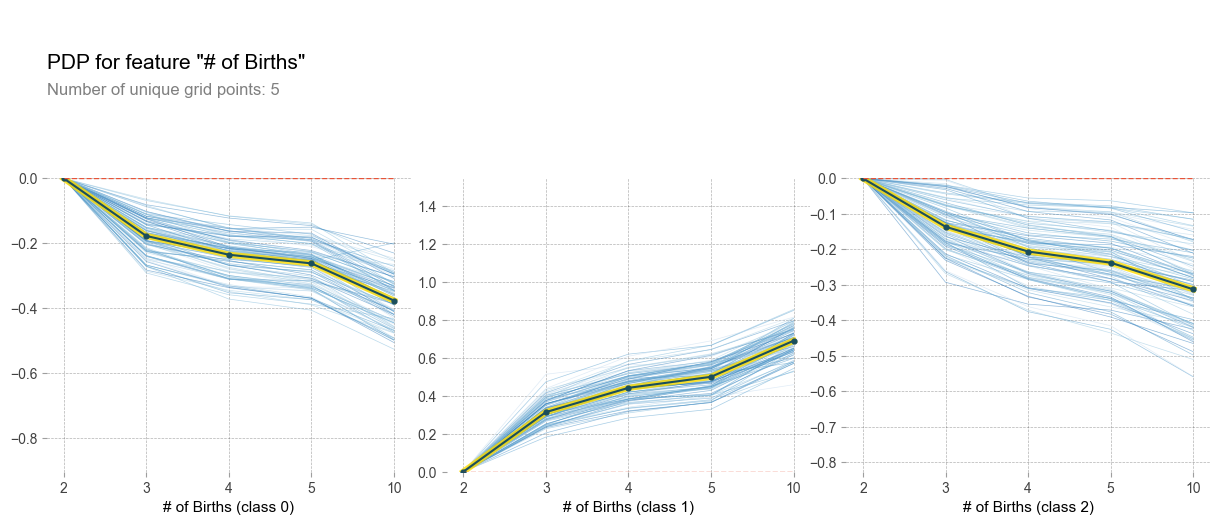

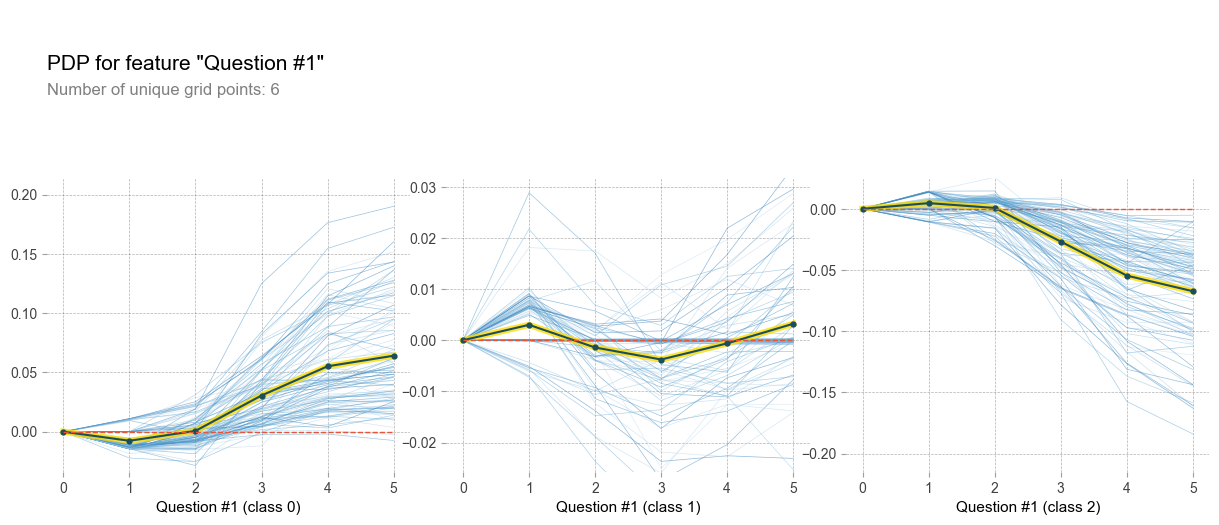

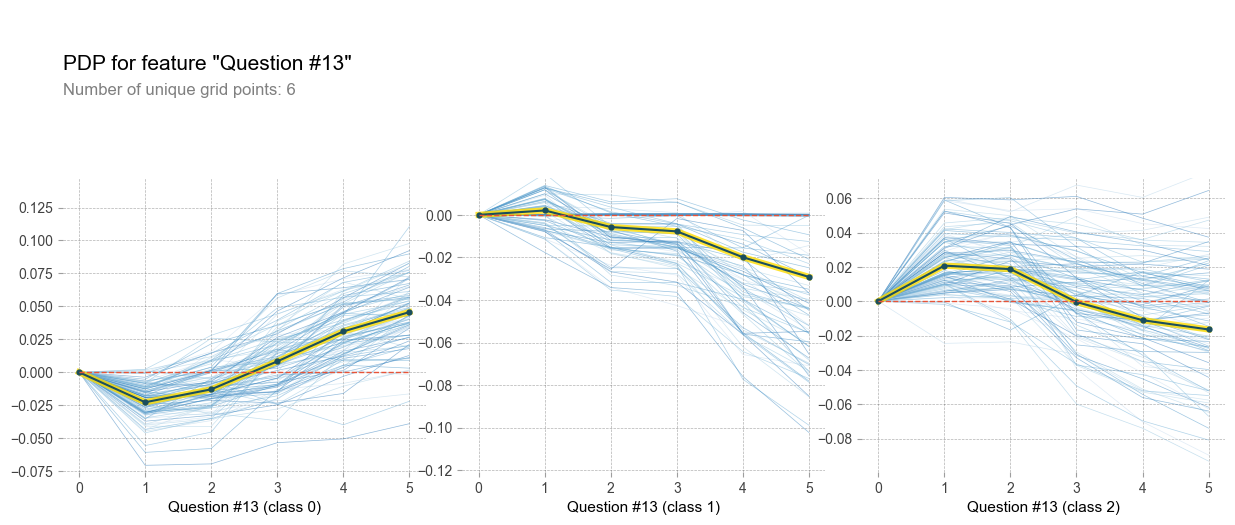

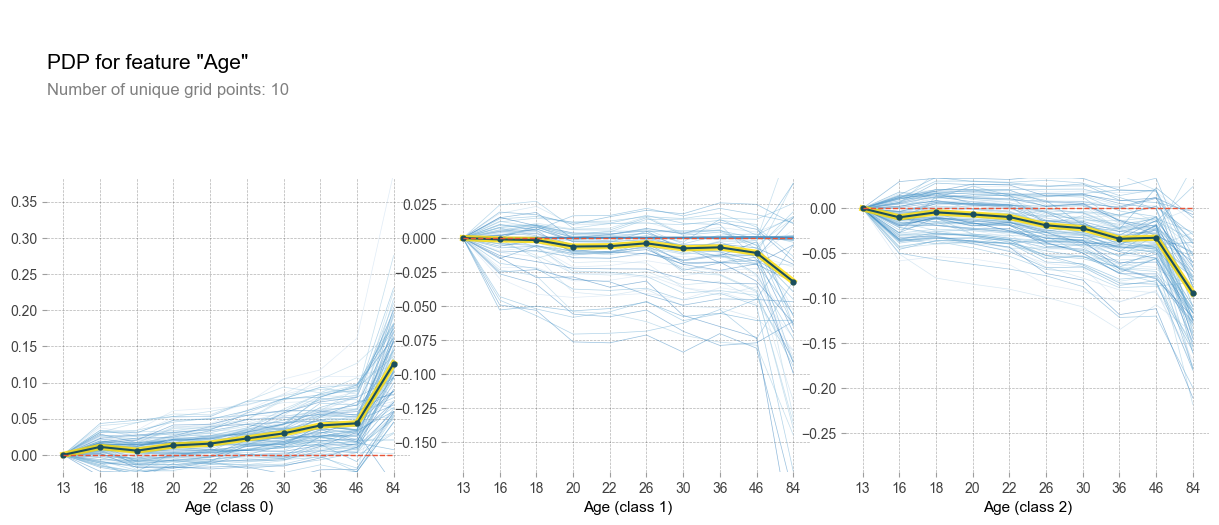

In [47]:
for i in range(len(feature_names)):
    pdp_feat_df = pdp.pdp_isolate(\
        model=class_models['gradient_boosting']['fitted'],\
        dataset=pd.concat((X_test, y_test), axis=1),\
        model_features=X_test.columns,\
        feature=feature_names[i]
    )
    fig, axes = pdp.pdp_plot(
        pdp_isolate_out=pdp_feat_df, center=True,\
        x_quantile=True, ncols=3, plot_lines=True,\
        frac_to_plot=100, figsize=(15,6),\
        feature_name=feature_labels[i]
    )

In [48]:
# bewware of class imbalance across features --- in this instance - oldest child overrpresented in last age group. 

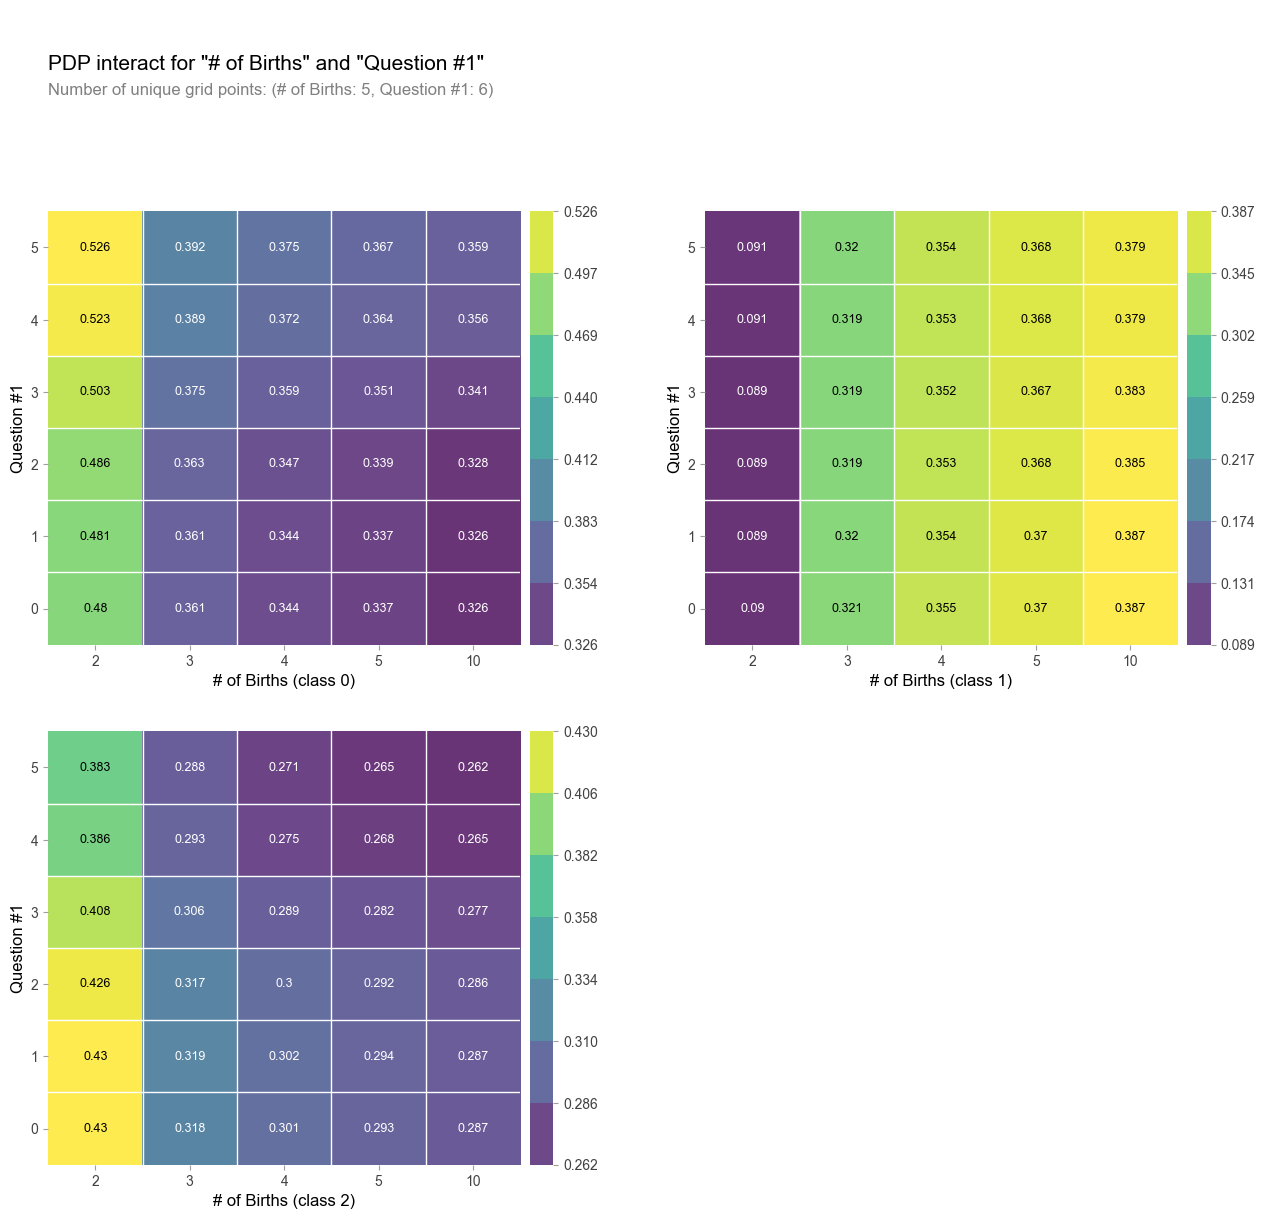

In [49]:
pdp_birthn_Q1_df = pdp.pdp_interact(
    model=class_models['random_forest']['fitted'],\
    dataset=pd.concat((X_test, y_test), axis=1),\
    model_features=X_test.columns, features=['birthn','Q1'],\
    n_jobs=-1
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=pdp_birthn_Q1_df,\
    plot_type='grid', x_quantile=True,\
    ncols=2, figsize=(15,15),\
    feature_names=['# of Births','Question #1']
)

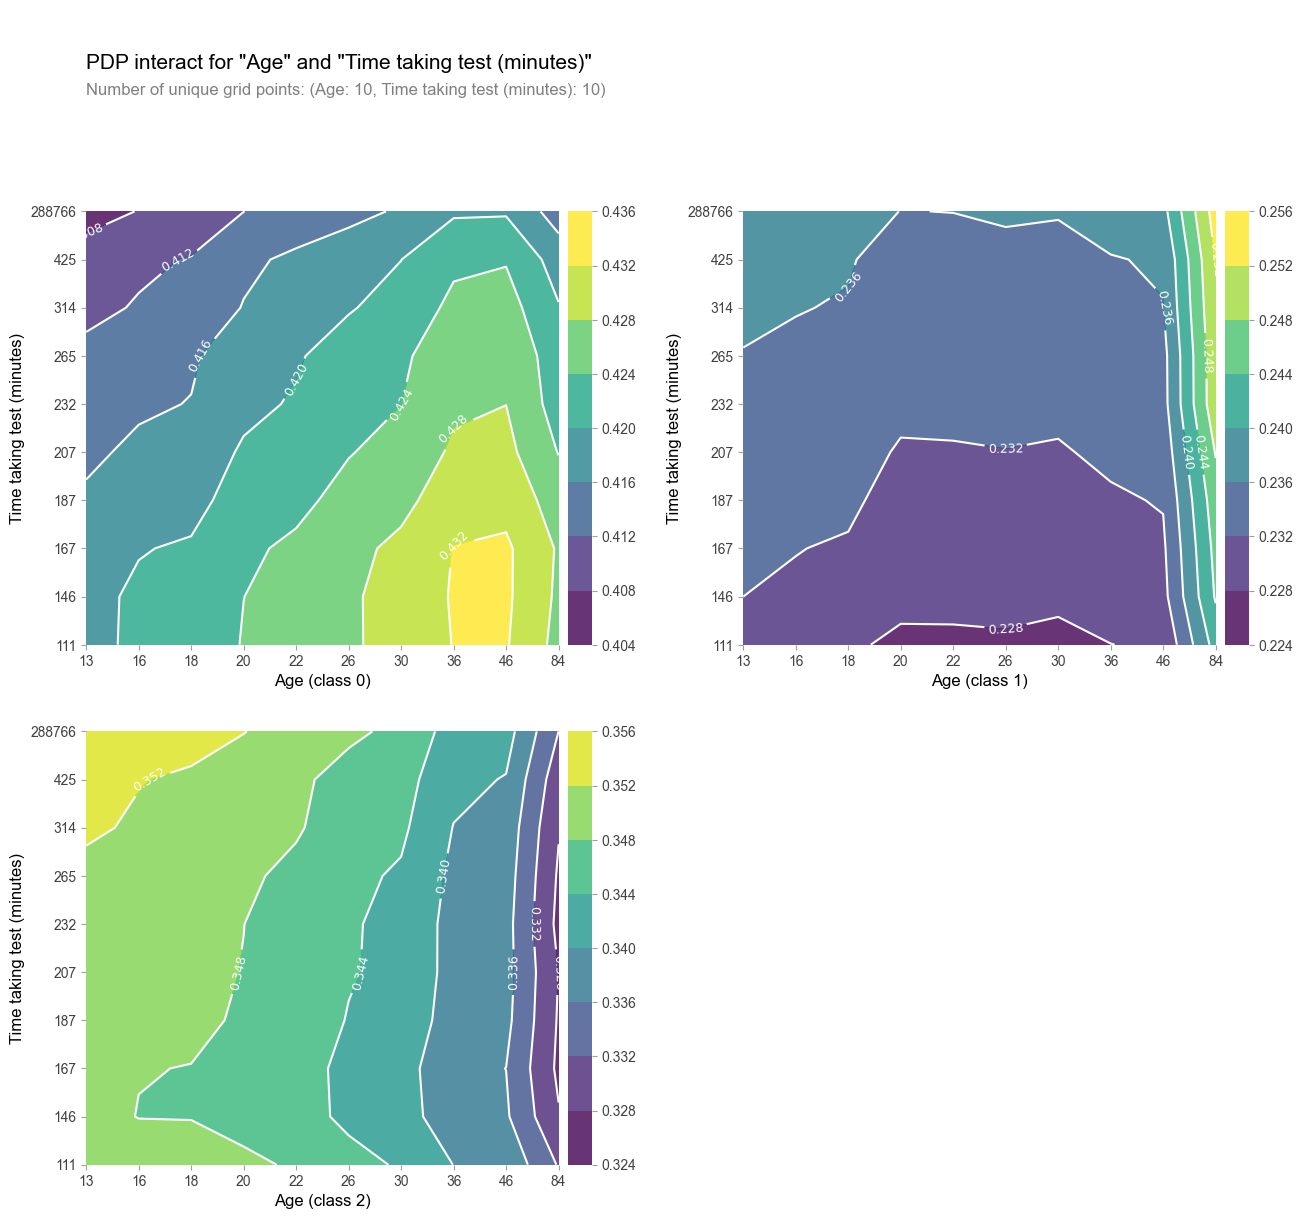

In [50]:
pdp_age_testelapse_df = pdp.pdp_interact(
    model=class_models['random_forest']['fitted'],\
    dataset=pd.concat((X_test, y_test), axis=1),\
    model_features=X_test.columns, features=['age','testelapse'],\
    n_jobs=-1
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=pdp_age_testelapse_df,\
    plot_type='contour', x_quantile=True,\
    ncols=2, figsize=(15,15),\
    feature_names=['Age','Time taking test (minutes)']
)